# Melanoma Classification with Convolutional Neural Networks

We will used the Melanoma ISIC Dataset
(https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main)

Download the images and metadata using the API for that purpose.

In [1]:
!git clone https://github.com/GalAvineri/ISIC-Archive-Downloader

Cloning into 'ISIC-Archive-Downloader'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 292 (delta 0), reused 0 (delta 0), pack-reused 288
Receiving objects: 100% (292/292), 75.17 KiB | 636.00 KiB/s, done.
Resolving deltas: 100% (175/175), done.


In [2]:
## One Option is Before download the images, edit the download_archive.py in line 207, setting directly ----> res='y'
## Another option is to click just besides [y/n] and type 'y' then enter

## It will create a 'Data' Folder with sub-folders Description and Images
#!python ISIC-Archive-Downloader/download_archive.py --num-images=1000 ## works but download an unbalance dataset
!python ISIC-Archive-Downloader/download_archive.py --num-images 100 --filter malignant
!python ISIC-Archive-Downloader/download_archive.py --num-images 100 --filter benign --offset 100


You have decided to do the following:
Download maximum of 100 elements
start with offset 0
filter only malignant images
Descriptions will be downloaded to /content/Data/Descriptions
Images will be downloaded to /content/Data/Images
Use 16 processes to download the archive
Do you confirm your choices? [Y/n] Y
Invalid input. Do you confirm your choices? [Y/n] Y
Invalid input. Do you confirm your choices? [Y/n] y
Malignants Found: 100% 100/100 [01:45<00:00,  1.06s/it]
Found 100 malignant images
Finished downloading
You have decided to do the following:
Download maximum of 100 elements
start with offset 100
filter only benign images
Descriptions will be downloaded to /content/Data/Descriptions
Images will be downloaded to /content/Data/Images
Use 16 processes to download the archive
Do you confirm your choices? [Y/n] y
Benigns Found: 100% 100/100 [00:37<00:00,  2.70it/s]
Found 100 benign images
Finished downloading


In [3]:
# Now let's import some useful packages
import json
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image


In [4]:
# Lets organize the data
desc_path = 'Data/Descriptions/'
images_path = 'Data/Images/'

df_files = pd.DataFrame(os.listdir(desc_path), columns=['Name'])
print(df_files.head())

           Name
0  ISIC_0000101
1  ISIC_0000287
2  ISIC_0000133
3  ISIC_0000078
4  ISIC_0000224


In [5]:
label = []
label_value = []
for ii in range(len(df_files)):
  filename = os.path.join(desc_path,df_files['Name'][ii])

  with open(filename) as read_file:

    data=json.load(read_file)

    
  #retrieve the label from the metadata
  label.append(data['meta']['clinical']['benign_malignant'])
  label_value.append( 0 if data['meta']['clinical']['benign_malignant']=='benign' else 1)

print(len(label))

200


In [6]:
# Append the label to the DataFrame
df_files['label']= label
df_files['label_value']= label_value


In [7]:
df_files.head()

,Name,label,label_value
0,ISIC_0000101,benign,0
1,ISIC_0000287,malignant,1
2,ISIC_0000133,benign,0
3,ISIC_0000078,malignant,1
4,ISIC_0000224,benign,0


In [8]:
df_files.loc[10,:]

Name           ISIC_0000046
label             malignant
label_value               1
Name: 10, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2660c5a50>]],
      dtype=object)

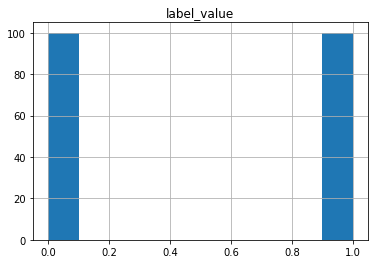

In [9]:
df_files.hist(column='label_value')
# Now we check if the data are balanced.

(1704, 2272, 3)
benign


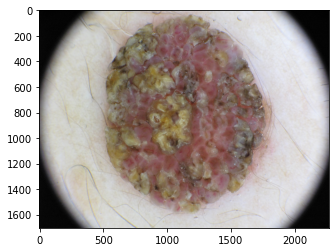

In [10]:
img = plt.imread(os.path.join(images_path,df_files['Name'][0]+'.jpeg' ))
print(img.shape)
print(df_files['label'][0])
plt.imshow(img)

# Import Pytorch packages

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import time
from torchvision import transforms, utils
from torchsummary import summary
import copy
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

In [12]:
## Lets define the dataset for training and testing. Check the stratify option. Can you think about why it is important this feature?

df_files_train, df_files_test = train_test_split(df_files, test_size=0.2, random_state=42, stratify=df_files.label_value  )
print(len(df_files_train))
print(len(df_files_test))

df_files_train=df_files_train.reset_index()
df_files_test=df_files_test.reset_index()


160
40


In [13]:
# Create Dataset
class Dataset(torch.utils.data.Dataset):
  def __init__(self, img_path, desc_path, df_files, transforms):
    
    self.transforms  = transforms
    self.img_path  = img_path
    self.desc_path = desc_path 
    self.df_files = df_files
    
  def __len__(self,):
    # ToDO... Complete to make it work
    return len(self.df_files)
  
  def __getitem__(self, idx):
    image  = Image.open(os.path.join(self.img_path, self.df_files['Name'][idx]+'.jpeg' ))
    # ToDO:  complete to make it work
    image_name = self.df_files['Name'][idx]

    target = np.array(self.df_files['label_value'][idx])

    if self.transforms:
      image = self.transforms(image)

    return {
        
        'image_name':image_name,
        'image': image,
        # ToDo... complete to make it work
        'target': torch.from_numpy( target ).long()
    }

composed = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(256),
                               transforms.RandomCrop(224),
                               #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])

## Create the object
dataset_train= Dataset(img_path=images_path,
                       desc_path=desc_path,
                       df_files=df_files_train,
                       transforms=composed )

## Create the object
dataset_test = Dataset(img_path=images_path,
                       desc_path=desc_path,
                       df_files=df_files_test,
                       transforms=composed )  



In [14]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=9, shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=9, shuffle=False, num_workers=0)


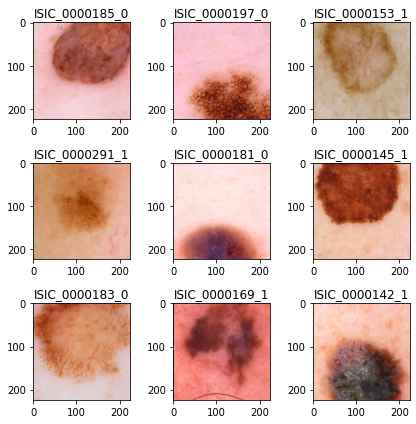

In [16]:
# from https://juansensio.com/blog/065_transformer_decoder
for data in train_loader:
  # print(data)
  r, c = 3,3
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)
      img = data['image'][ix].cpu().numpy().transpose()
      label = data['target'][ix].cpu().numpy()

      ax.imshow(img)
      ax.set_title( data['image_name'][ix]+'_'+str(label))
  plt.tight_layout()
  plt.show()
  
  break


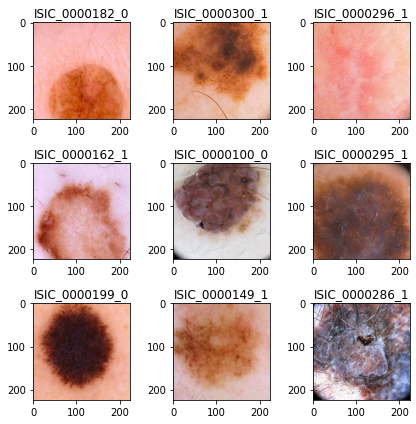

In [17]:
# from https://juansensio.com/blog/065_transformer_decoder
for data in test_loader:
  # print(data)
  r, c = 3,3
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)
      img = data['image'][ix].cpu().numpy().transpose()
      label = data['target'][ix].cpu().numpy()

      ax.imshow(img)
      ax.set_title( data['image_name'][ix]+'_'+str(label))
  plt.tight_layout()
  plt.show()
  
  break

In [18]:
# Define a MLP MODEL for benchmark later the CNN performance
# TODO: Complete to make it work, the number of input features and output features.
model_MLP = nn.Sequential(
    nn.Linear(224*224*3, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000,128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1)
)


In [19]:
print(model_MLP)

Sequential(
  (0): Linear(in_features=150528, out_features=1000, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=1000, out_features=128, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=128, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)


In [20]:
# TODO 
summary(model_MLP, input_size=(1, 3*224*224), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]     150,529,000
              ReLU-2              [-1, 1, 1000]               0
            Linear-3               [-1, 1, 128]         128,128
              ReLU-4               [-1, 1, 128]               0
            Linear-5                 [-1, 1, 2]             258
        LogSoftmax-6                 [-1, 1, 2]               0
Total params: 150,657,386
Trainable params: 150,657,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.02
Params size (MB): 574.71
Estimated Total Size (MB): 575.30
----------------------------------------------------------------


In [21]:
# Create Dataset
# ToDO: Complete to make it work
class Dataset(torch.utils.data.Dataset):
  def __init__(self, img_path, desc_path, df_files, transforms):
    
    self.transforms  = transforms
    self.img_path  = img_path
    self.desc_path = desc_path 
    self.df_files = df_files

    
    
  def __len__(self,):
    return len(self.df_files)
  
  def __getitem__(self, idx):
    image  = Image.open(os.path.join(self.img_path, self.df_files['Name'][idx]+'.jpeg' ))
    image_name = self.df_files['Name'][idx]
    # im = Image.open("D:/images/sample-image.png")

    target = np.array(self.df_files['label_value'][idx])

    if self.transforms:
      image = self.transforms(image)

    return {
        'image_name':image_name,
        'image': image,
        'target': torch.from_numpy( target ).long()
    }

composed = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(256),
                               transforms.RandomCrop(224),
                               #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])

## Create the object
dataset_train= Dataset(img_path=images_path,
                       desc_path=desc_path,
                       df_files=df_files_train,
                       transforms=composed )

## Create the object
dataset_test = Dataset(img_path=images_path,
                       desc_path=desc_path,
                       df_files=df_files_test,
                       transforms=composed )  

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64, shuffle=True, num_workers=0,drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=4, shuffle=False, num_workers=0,drop_last=True)


In [22]:
def test_loop_MLP(test_loader, criterion, model, DEVICE):
  model.to(DEVICE)
  pred = [] #torch.zeros(10000,1)
  correct = 0
  loss=[] 
  for test_data in test_loader:
    with torch.no_grad():
      bz, _, _, _ = test_data['image'].shape 
      y_pred = model( test_data['image'].view(bz,-1).to(DEVICE) )
      loss.append( criterion(y_pred, test_data['target'].to(DEVICE)).item() )

    _,predicted = torch.max(y_pred.data, 1)
    correct += predicted.eq(test_data['target'].to(DEVICE).view_as(predicted)).sum().item()
  loss = np.array(loss)
  acc = 100. * correct / len(test_loader.dataset)
  return acc, loss.mean()
  #print(f' Test set Accuracy: {correct}/{len(test_loader.dataset)}:  {acc :.2f}%' )

def trainer_MLP(train_loader,test_loader, model, optimizer, num_epochs, criterion,DEVICE  ):
  best_acc=0
  model.to(DEVICE)
  model_best = copy.deepcopy(model)
  model.train()
  train_loss =  []
  start = time.time()
  print('='*30)
  print("INIT TRAINING")
  train_loss_epochs = []
  val_loss_epochs = []
  for epoch in range(num_epochs):
    train_loss_iter = []
    for train_data in train_loader:

      # TODO ...
      # zero gradients
      optimizer.zero_grad()
      
      # forward pass
      bz, _, _, _ = train_data['image'].shape 
      y_pred = model( train_data['image'].view(bz,-1).to(DEVICE)  )
      #print('Y_pred: ',y_pred)
      #y_pred = model( train_data['image'].to(DEVICE) )
      loss = criterion(y_pred, train_data['target'].to(DEVICE))
      # Backward pass
      loss.backward()
      train_loss_iter.append(loss.item())
      
      # TODO...
      #optimizer step 
      optimizer.step()

    val_acc_epoch, val_loss_epoch = test_loop_MLP(test_loader, criterion, model, DEVICE)

    if val_acc_epoch > best_acc:
      model_best = copy.deepcopy(model)
      best_acc = val_acc_epoch
      print('Guardo Best')

    train_loss_iter=np.array(train_loss_iter)
    train_loss_epochs.append(train_loss_iter.mean())
    print(f'Trainig EPOCH {epoch} \t loss_train: {train_loss_iter.mean()} \t Val_LOSS:{val_loss_epoch} \t Val_ACC:{val_acc_epoch} ')
    
    val_loss_epochs.append(val_loss_epoch)

  
  train_loss_epochs = np.array(train_loss_epochs)
  val_loss_epochs = np.array(val_loss_epochs)
  end = time.time()
  print(f'Trainig duration: {end - start}')
  print('='*30)
  plt.plot(train_loss_epochs)
  plt.plot(val_loss_epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  return model_best


INIT TRAINING
Guardo Best
Trainig EPOCH 0 	 loss_train: 861.4395897984505 	 Val_LOSS:2457.6337280273438 	 Val_ACC:50.0 
Trainig EPOCH 1 	 loss_train: 1562.8968200683594 	 Val_LOSS:747.2931030273437 	 Val_ACC:50.0 
Trainig EPOCH 2 	 loss_train: 657.405029296875 	 Val_LOSS:202.77295684814453 	 Val_ACC:50.0 
Trainig EPOCH 3 	 loss_train: 234.62691497802734 	 Val_LOSS:211.3098045349121 	 Val_ACC:50.0 
Trainig EPOCH 4 	 loss_train: 168.69113159179688 	 Val_LOSS:16.71625690460205 	 Val_ACC:50.0 
Trainig EPOCH 5 	 loss_train: 31.2808198928833 	 Val_LOSS:34.6706521987915 	 Val_ACC:50.0 
Trainig EPOCH 6 	 loss_train: 24.02734136581421 	 Val_LOSS:8.476594543457031 	 Val_ACC:50.0 
Trainig EPOCH 7 	 loss_train: 5.421797156333923 	 Val_LOSS:24.7955283164978 	 Val_ACC:50.0 
Trainig EPOCH 8 	 loss_train: 15.072693109512329 	 Val_LOSS:38.13423900604248 	 Val_ACC:50.0 
Trainig EPOCH 9 	 loss_train: 19.374977231025696 	 Val_LOSS:9.590742707252502 	 Val_ACC:50.0 
Trainig duration: 73.3792929649353


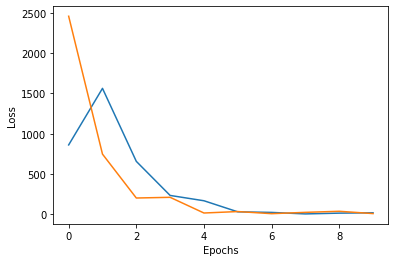

In [23]:

DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs=10
learning_rate = 0.01
criterion = nn.NLLLoss() #nn.BCELoss() # nn.NLLLoss() #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=learning_rate)
model_MLP = trainer_MLP(train_loader, test_loader, model_MLP, optimizer, num_epochs, criterion, DEVICE)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40

Batch Accuracy: 50.0%


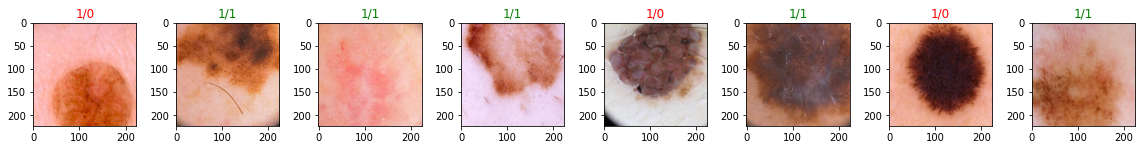

In [24]:
test_loader2= torch.utils.data.DataLoader(dataset=dataset_test, batch_size=len(df_files_test), shuffle=False, num_workers=0,drop_last=True)

for test_data in test_loader2:
  
  with torch.no_grad():
    bz, _, _, _ = test_data['image'].shape 
    y_pred = model_MLP( test_data['image'].view(bz,-1).to(DEVICE) )
      
  _, predicted = torch.max(y_pred.data, 1)

  
  print(classification_report( test_data['target'].cpu(), predicted.cpu() ))
  acc = predicted.eq(test_data['target'].to(DEVICE)).sum()
  print(f'Batch Accuracy: {acc.item()/predicted.shape[0]*100}%' )


  # from https://juansensio.com/blog/065_transformer_decoder
  r, c = 1,8
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)

      img = test_data['image'][ix].cpu().numpy().transpose()
      label = test_data['target'][ix].cpu().numpy()

      
      pred = predicted[ix].cpu().numpy().item()
      ax.imshow(img)
      ax.set_title( str(pred)+'/'+str(label), color='green' if label==pred else 'red'  )
  plt.tight_layout()
  plt.show()



  break

# Convolutional Neural NEtworks

Now, lets define a ConvNet that in previous lectures we have seen that works better with images.

In [25]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1) # 128,320/2,160
    self.relu = nn.ReLU(inplace=True)
    ## The maxpool and convnets 
    self.maxpool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)# 256,160/2,80
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)# 512,80/2,40
    self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)# 1024,40/2,20
    self.conv5 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)# 1024,20/2,10
    
    ## The MLP takes the features maps created by the convnets.  

    self.mlp = nn.Sequential(
        nn.Linear( 1024 * 7 * 7, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    print(x.shape)
    x = self.relu(self.maxpool(self.conv1(x)))
    print(x.shape)

    x = self.relu(self.maxpool(self.conv2(x)))
    print(x.shape)
    x = self.relu(self.maxpool(self.conv3(x)))
    print(x.shape)
    x = self.relu(self.maxpool(self.conv4(x)))
    x = self.relu(self.maxpool(self.conv5(x)))

    print(x.shape)

    bsz, nch, height, width = x.shape
    x = x.view(bsz, -1)
    print(x.shape)
    y = self.mlp(x)
    return y

In [26]:
model_cnn = CNN()
# ToDO...  
## Compare the amount of parameters with the MLP
summary(model_cnn, input_size=(3,224,224), device='cpu')


torch.Size([2, 3, 224, 224])
torch.Size([2, 128, 112, 112])
torch.Size([2, 256, 56, 56])
torch.Size([2, 512, 28, 28])
torch.Size([2, 1024, 7, 7])
torch.Size([2, 50176])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           3,584
         MaxPool2d-2        [-1, 128, 112, 112]               0
              ReLU-3        [-1, 128, 112, 112]               0
            Conv2d-4        [-1, 256, 112, 112]         295,168
         MaxPool2d-5          [-1, 256, 56, 56]               0
              ReLU-6          [-1, 256, 56, 56]               0
            Conv2d-7          [-1, 512, 56, 56]       1,180,160
         MaxPool2d-8          [-1, 512, 28, 28]               0
              ReLU-9          [-1, 512, 28, 28]               0
           Conv2d-10         [-1, 1024, 28, 28]       4,719,616
        MaxPool2d-11         [-1, 1024, 14, 14]               

In [27]:
def test_loop_CNN(test_loader, criterion, model, DEVICE):
  model.to(DEVICE)
  pred = [] #torch.zeros(10000,1)
  correct = 0
  loss=[] 
  for test_data in test_loader:
    with torch.no_grad():
      #bz, _, _, _ = test_data['image'].shape 
      y_pred = model( test_data['image'].to(DEVICE) )
      loss.append( criterion(y_pred, test_data['target'].to(DEVICE)).item() )

    _,predicted = torch.max(y_pred.data, 1)
    correct += predicted.eq(test_data['target'].to(DEVICE).view_as(predicted)).sum().item()
  loss = np.array(loss)
  acc = 100. * correct / len(test_loader.dataset)
  return acc, loss.mean()
  #print(f' Test set Accuracy: {correct}/{len(test_loader.dataset)}:  {acc :.2f}%' )

def trainer_CNN(train_loader,test_loader, model, optimizer, num_epochs, criterion,DEVICE  ):
  best_acc=0
  model_best = copy.deepcopy(model)
  model.to(DEVICE)
  model.train()
  train_loss =  []
  start = time.time()
  print('='*30)
  print("INIT TRAINING")
  train_loss_epochs = []
  val_loss_epochs = []
  for epoch in range(num_epochs):
    train_loss_iter = []
    for train_data in train_loader:
      # zero gradients
      optimizer.zero_grad()
      # forward pass
      #bz, _, _, _ = train_data['image'].shape 
      y_pred = model( train_data['image'].to(DEVICE) )
      #print('Y_pred: ',y_pred)
      #y_pred = model( train_data['image'].to(DEVICE) )
      loss = criterion(y_pred, train_data['target'].to(DEVICE))
      # Backward pass
      loss.backward()
      train_loss_iter.append(loss.item())
      #optimizer step 
      optimizer.step()

    val_acc_epoch, val_loss_epoch = test_loop_CNN(test_loader, criterion, model, DEVICE)
    if val_acc_epoch > best_acc:
      model_best = copy.deepcopy(model)
      best_acc = val_acc_epoch
      print('Guardo Best')

    train_loss_iter=np.array(train_loss_iter)
    train_loss_epochs.append(train_loss_iter.mean())
    print(f'Trainig EPOCH {epoch} \t loss_train: {train_loss_iter.mean()} \t Val_LOSS:{val_loss_epoch} \t Val_ACC:{val_acc_epoch} ')
    
    val_loss_epochs.append(val_loss_epoch)

  
  train_loss_epochs = np.array(train_loss_epochs)
  val_loss_epochs = np.array(val_loss_epochs)
  end = time.time()
  print(f'Trainig duration: {end - start}')
  print('='*30)
  plt.plot(train_loss_epochs)
  plt.plot(val_loss_epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  return model_best


INIT TRAINING
torch.Size([64, 3, 224, 224])
torch.Size([64, 128, 112, 112])
torch.Size([64, 256, 56, 56])
torch.Size([64, 512, 28, 28])
torch.Size([64, 1024, 7, 7])
torch.Size([64, 50176])
torch.Size([64, 3, 224, 224])
torch.Size([64, 128, 112, 112])
torch.Size([64, 256, 56, 56])
torch.Size([64, 512, 28, 28])
torch.Size([64, 1024, 7, 7])
torch.Size([64, 50176])
torch.Size([4, 3, 224, 224])
torch.Size([4, 128, 112, 112])
torch.Size([4, 256, 56, 56])
torch.Size([4, 512, 28, 28])
torch.Size([4, 1024, 7, 7])
torch.Size([4, 50176])
torch.Size([4, 3, 224, 224])
torch.Size([4, 128, 112, 112])
torch.Size([4, 256, 56, 56])
torch.Size([4, 512, 28, 28])
torch.Size([4, 1024, 7, 7])
torch.Size([4, 50176])
torch.Size([4, 3, 224, 224])
torch.Size([4, 128, 112, 112])
torch.Size([4, 256, 56, 56])
torch.Size([4, 512, 28, 28])
torch.Size([4, 1024, 7, 7])
torch.Size([4, 50176])
torch.Size([4, 3, 224, 224])
torch.Size([4, 128, 112, 112])
torch.Size([4, 256, 56, 56])
torch.Size([4, 512, 28, 28])
torch.Size(

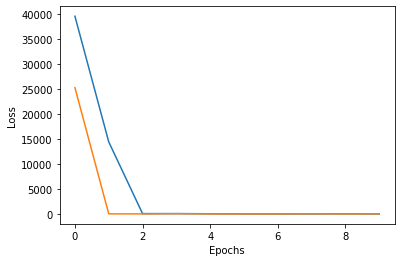

In [28]:
model_cnn = CNN()
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs=10
learning_rate = 0.01
criterion = nn.NLLLoss() #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)
model_cnn=trainer_CNN(train_loader, test_loader, model_cnn, optimizer, num_epochs, criterion,DEVICE  )


torch.Size([40, 3, 224, 224])
torch.Size([40, 128, 112, 112])
torch.Size([40, 256, 56, 56])
torch.Size([40, 512, 28, 28])
torch.Size([40, 1024, 7, 7])
torch.Size([40, 50176])
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40

Batch Accuracy: 50.0%


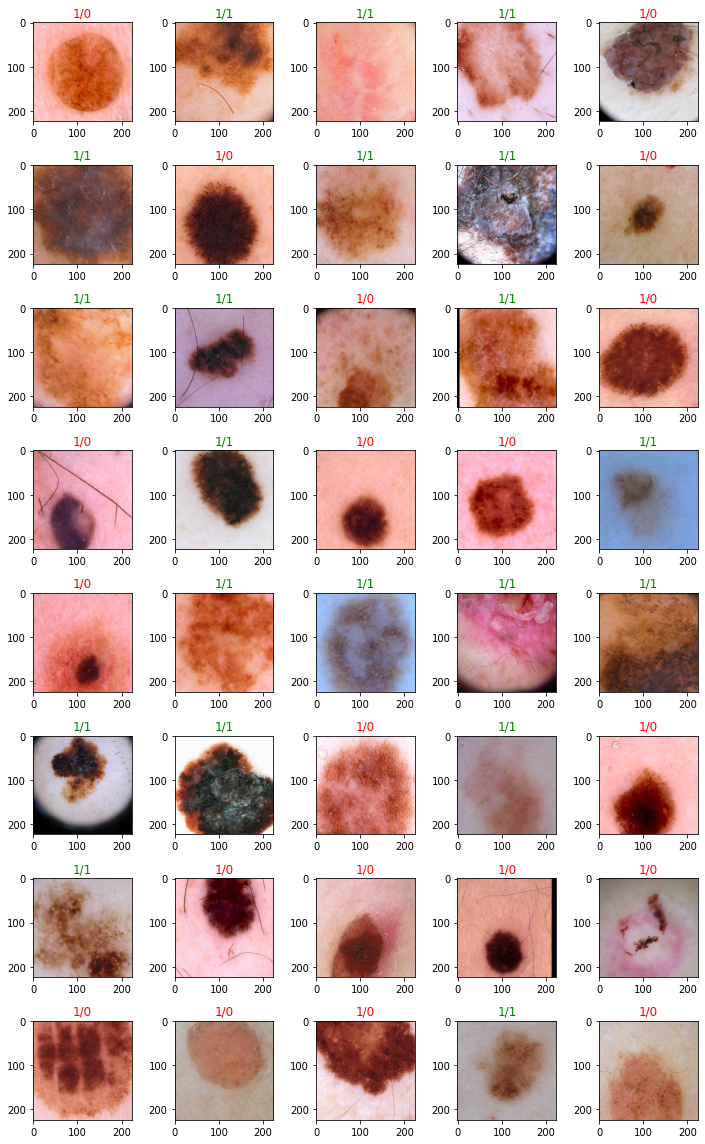

In [29]:
test_loader2 = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=len(df_files_test), shuffle=False, num_workers=0,drop_last=True)



for test_data in test_loader2:
  
  
  with torch.no_grad():
    y_pred = model_cnn( test_data['image'].to(DEVICE) )

  
  # TODO... Complete to make it work.. compare the accuracy obtained with MLP.
  _, predicted = torch.max(y_pred.data, 1)

  
  print(classification_report( test_data['target'].cpu(), predicted.cpu() ))

  acc = predicted.eq(test_data['target'].to(DEVICE)).sum()
  print(f'Batch Accuracy: {acc.item()/predicted.shape[0]*100}%' )


  # from https://juansensio.com/blog/065_transformer_decoder
  r, c = 8,5
  fig = plt.figure(figsize=(c*2,r*2) )
  for r_ in range(r):
    for c_ in range(c):
      ix = r_*c + c_ 
      ax = plt.subplot(r,c, ix+1)

      img = test_data['image'][ix].cpu().numpy().transpose()
      label = test_data['target'][ix].cpu().numpy()

      
      pred = predicted[ix].cpu().numpy().item()
      ax.imshow(img)
      ax.set_title( str(pred)+'/'+str(label), color='green' if label==pred else 'red'  )
  plt.tight_layout()
  plt.show()



  break